# Analyse the optimal KdV solutions

## TODO

 - Get a time series of $a_0$
 - Plot the results in $L_s/L - A_{max}/a_0$ space 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py


from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV



import matplotlib as mpl

import yaml

In [2]:
%matplotlib notebook

In [3]:
# Load the csv file with the representative beta's and target A_max
outfilestr = '../data/ekdv_optimal_a0_Prelude'
outcsvfile = '../data/ekdv_Prelude_results.csv'
csvfile = '../data/vkdv_inputs_prelude.csv'
x_pt = 101500

#csvfile = '../data/vkdv_inputs_imospil200.csv'
#outfilestr = '../data/ekdv_optimal_a0_PILIMOS'
#outcsvfile = '../data/ekdv_PILIMOS_results.csv'
#x_pt = 53500


#csvfile = '../data/vkdv_inputs_mode2_imospil200.csv'
#outfilestr = '../data/kdv_mode2_optimal_a0_PILIMOS'
#outcsvfile = '../data/kdv_mode2_PILIMOS_results.csv'
#x_pt = 53500



#pd.read_csv?
data = pd.read_csv(csvfile, sep=', ', parse_dates=['time','timemax'], index_col='time')

data.head()

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


,timemax,Amax,beta0,beta1,beta2,beta3,beta4,beta5
time,,,,,,,,
2016-05-01,2016-05-01 22:49:00,-17.517,1023.464,1.281,59.462,25.583,83.175,44.421
2016-05-02,2016-05-02 17:26:00,-16.563,1023.489,1.281,59.431,27.549,84.906,47.735
2016-05-03,2016-05-03 20:50:00,19.584,1023.489,1.281,59.800,26.636,84.889,50.688
2016-05-04,2016-05-04 23:28:00,25.726,1023.505,1.283,59.814,27.861,86.798,53.998
2016-05-05,2016-05-05 18:50:00,-26.879,1023.528,1.282,60.298,29.466,86.836,56.151


<IPython.core.display.Javascript object>


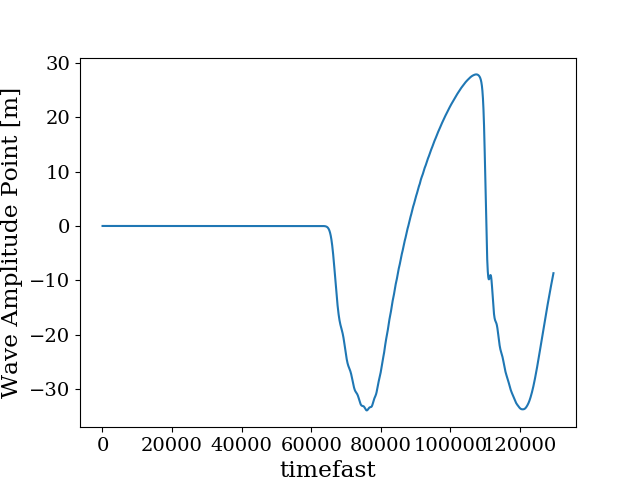

-33.98126885503733 75960.0


In [18]:
# Test for computing the time of maximum
def maximum_amplitude_finder(amp_signal):
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]
    
ds.B_pt.plot()
Amax, tidx = maximum_amplitude_finder(ds.B_pt.values)
print(Amax, ds.timefast.values[tidx])

In [21]:
a0 = []
Amax = []
Tmax = []
Ls = []
Ls_l = []
C_x = []
alpha_x = []
beta_x = []
time = []

for tt,tnow in enumerate(data.index):
    outfile = '%s_%s.nc'%(outfilestr,tnow.strftime('%Y-%m-%d'))
    try:
        ds = xr.open_dataset(outfile)
    except:
        continue
    
    a0.append(ds.a0)
    #Amax.append(ds.Amax)
    time.append(tnow)
    
    Amax_now, tidx = maximum_amplitude_finder(ds.B_pt.values)
    Tmax.append(ds.timefast.values[tidx])
    Amax.append(Amax_now)
    
    
    # Calculate mean quantities
    dx = ds.x.values[1]-ds.x.values[0]
    nx = ds.x.shape[0]
    L = np.arange(1,nx+1,1)*dx
    #L = 0.5*(Lend[1::] + Lend[0:-1])

    C_mu = np.cumsum(ds.Cn.values*dx) / L
    alpha_mu = np.cumsum(ds.Alpha.values*dx) / L

    Q_x = np.gradient(ds.Qterm.values,dx)
    beta = 0.5/ds.Qterm.values * Q_x
    beta_mu = np.cumsum(beta*dx) / L

    # Steepening length scale - using global values
    omega = 2*np.pi/(12.42*3600)
    c2 = C_mu*C_mu
    Ls_x = -c2 / (ds.a0* (alpha_mu*omega))# + c2*beta_mu))
    
    # Steepening length using local values (for testing...)
    omega = 2*np.pi/(12.42*3600)
    c2 = ds.Cn.values*ds.Cn.values
    Ls_x_local = -c2 / (ds.a0* (ds.Alpha.values))#*omega + c2*beta))
    

    idx = np.argwhere(ds.x.values>x_pt)[0,0]
    Ls.append(Ls_x[idx])
    Ls_l.append(Ls_x_local[idx])
    
    C_x.append(C_mu[idx])
    alpha_x.append(alpha_mu[idx])
    #break
    
a0 = np.array(a0)
Amax = np.array(Amax)
Tmax = np.array(Tmax)

Ls = np.array(Ls)
C_x = np.array(C_x)
alpha_x = np.array(alpha_x)
Ls_l = np.array(Ls_l)
time=np.array(time)

In [22]:
# Add the new data into the pandas DataFrame
data['a0'] = pd.Series(a0, index=time)
data['Ls'] = pd.Series(Ls, index=time)
data['alpha'] = pd.Series(alpha_x, index=time)
data['C'] = pd.Series(C_x, index=time)
data['Tmax'] = pd.Series(Tmax, index=time)

#data.to_csv(outcsvfile, float_format='%3.4f')
data.shape

(319, 13)

<IPython.core.display.Javascript object>


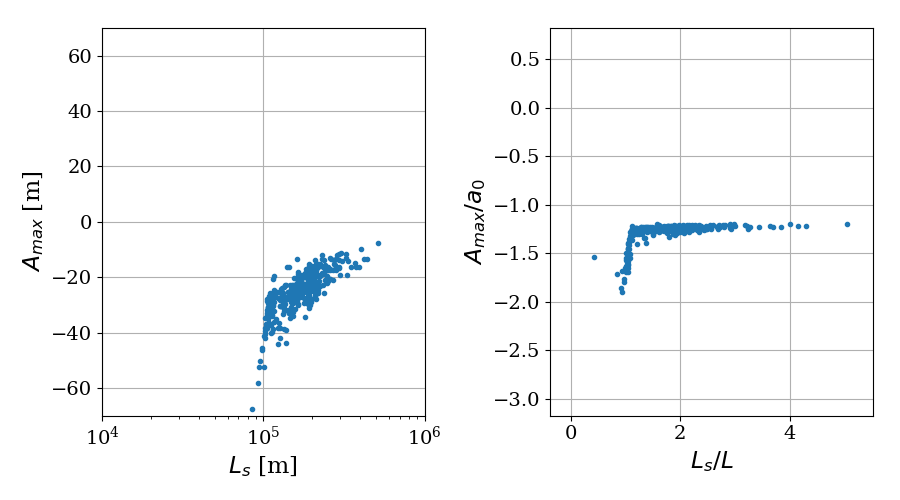

In [52]:
plt.figure(figsize=(9,5))
plt.subplot(122)
#plt.semilogx(Ls/x_pt, Amax/a0, '.')
plt.plot(Ls/x_pt, Amax/a0, '.')

#plt.semilogx(Ls_l/x_pt, Amax/a0, 'r.')
plt.grid(b=True)
plt.xlim(0.1,6)
plt.ylim(-2,2)
plt.xlabel('$L_s/L$')
plt.ylabel('$A_{max}/a_0$')
plt.tight_layout()

plt.subplot(121)

plt.semilogx(Ls, Amax, '.')
#plt.semilogx(Ls_l/x_pt, Amax/a0, 'r.')
plt.grid(b=True)
plt.xlim(1e4,1e6)
plt.ylim(-70,70)
plt.xlabel('$L_s$ [m]')
plt.ylabel('$A_{max}$ [m]')
plt.tight_layout()

<IPython.core.display.Javascript object>


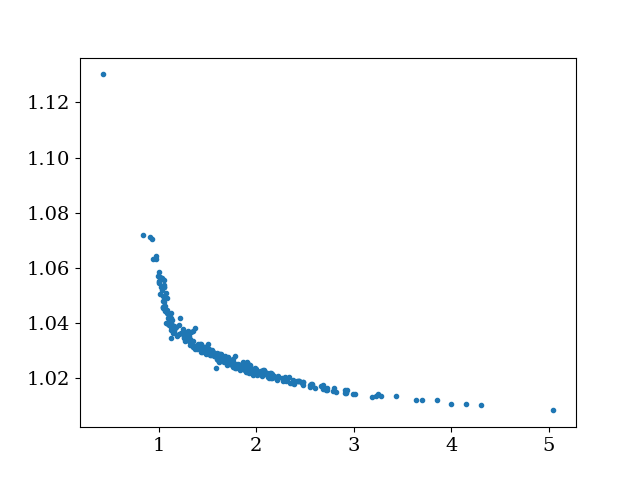

In [128]:
# C_nl = nonlinear propation speed
C_nl = C_x + 0.333*alpha_x*Amax

plt.figure()
plt.plot(Ls/x_pt , C_nl/C_x,'.')

<IPython.core.display.Javascript object>


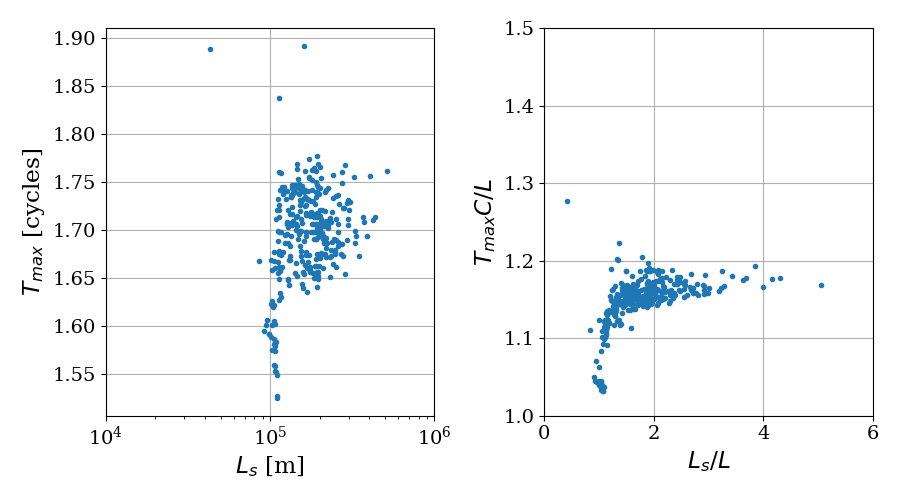

In [155]:
# Clean up Tmax by shifting stuff that is greater than a period out
Tmax_norm = Tmax/(12.42*3600)
Tmax_norm[Tmax_norm>2] = Tmax_norm[Tmax_norm>2]-1

#Tmax_norm = np.mod(Tmax/(12.42*3600),2)


plt.figure(figsize=(9,5))
plt.subplot(122)
#plt.semilogx(Ls/x_pt, Amax/a0, '.')
plt.plot(Ls/x_pt  ,  (Tmax_norm*C_x/x_pt)*12.42*3600 , '.')
#plt.plot(Ls/x_pt  ,  (Tmax_norm*C_nl/x_pt)*12.42*3600 , 'r.')

#plt.plot(Ls/x_pt  , (Tmax*C_x/x_pt) , '.')

#plt.plot(Amax/a0, Tmax*C_x/x_pt, '.')


#plt.semilogx(Ls_l/x_pt, Amax/a0, 'r.')
plt.grid(b=True)
plt.xlim(0.,6)
plt.ylim(1,1.5)
plt.xlabel('$L_s/L$')
plt.ylabel('$T_{max} C/L$')
plt.tight_layout()

plt.subplot(121)


plt.semilogx(Ls, Tmax_norm , '.')
#plt.semilogx(Ls_l/x_pt, Amax/a0, 'r.')
plt.grid(b=True)
plt.xlim(1e4,1e6)
#plt.ylim(-70,70)
plt.xlabel('$L_s$ [m]')
plt.ylabel('$T_{max}$ [cycles]')
plt.tight_layout()

<IPython.core.display.Javascript object>


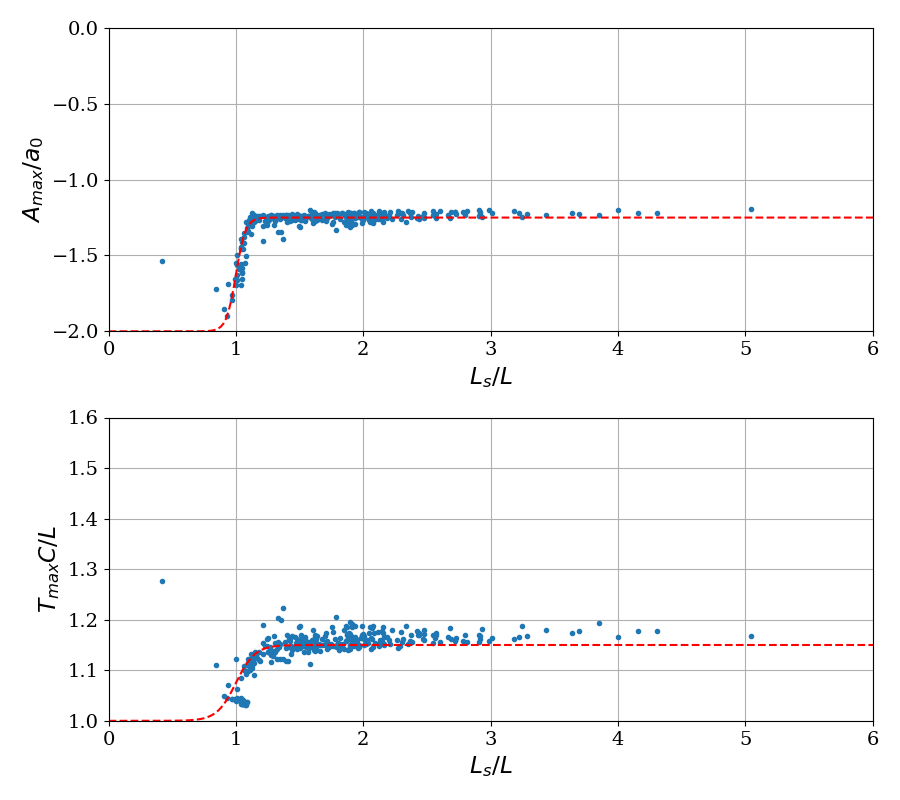

In [159]:
# Parametric form
def calc_Ahat(Lhat, Amax, A0, L0, dLA):
    #return dA*A0 + 0.5*dA*(1+np.tanh( (Lhat-L0)/dLA))
    #return A0*0.5*(2*dA + 1 + np.tanh( (Lhat-L0)/dLA))
    return -Amax + 0.5*(Amax-A0) * (1 + np.tanh( (Lhat-L0)/(0.5*dLA)) )


Lhat = np.linspace(0,10,500)
Ahat = calc_Ahat(Lhat, 2, 1.25, 1, 0.15)

That = calc_Ahat(Lhat, -1, -1.15, 1.0, 0.30)


plt.figure(figsize=(9,8))
plt.subplot(211)
plt.plot(Ls/x_pt, Amax/a0, '.')

plt.plot(Lhat, Ahat,'r--')

plt.grid(b=True)
plt.ylim(-2,0)
plt.xlim(0.,6)
plt.xlabel('$L_s/L$')
plt.ylabel('$A_{max}/a_0$')

plt.subplot(212)
#plt.plot(Ls/x_pt  , (Amax/a0) * (Tmax*C_x/x_pt) , '.')
plt.plot(Ls/x_pt  ,  (Tmax_norm*C_x/x_pt)*12.42*3600 , '.')
plt.plot(Lhat, That,'r--')

plt.grid(b=True)
plt.xlim(0.,6)
plt.ylim(1,1.6)
plt.xlabel('$L_s/L$')
plt.ylabel('$T_{max} C/L$')
plt.tight_layout()

plt.savefig('../FIGURES/Parametric_KDV_Prelude_topo.png',dpi=150)
plt.savefig('../FIGURES/Parametric_KDV_Prelude_topo.pdf',dpi=150)